# 优化算法
- 就是用来知道怎么调整参数才能高效、稳定的找到损失函数的最小或者较小值的数学方法（类似多元函数求极值问题的复杂化应用）
## 优化和深度学习
- 在做这个优化的过程中，涉及到前面机器学习的学习里面提到的两个东西就是经验风险（在训练集上的风险，我们不断调整来最小化预期风险的东西）和风险（预期风险，就是我们最终想要达到的最小化的东西），注意在训练的时候，不仅要关注到降低经验风险，还要注意到泛化差距（就是两种风险的差距，就是训练损失和验证损失的差距），这涉及到过拟合和欠拟合的问题。

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

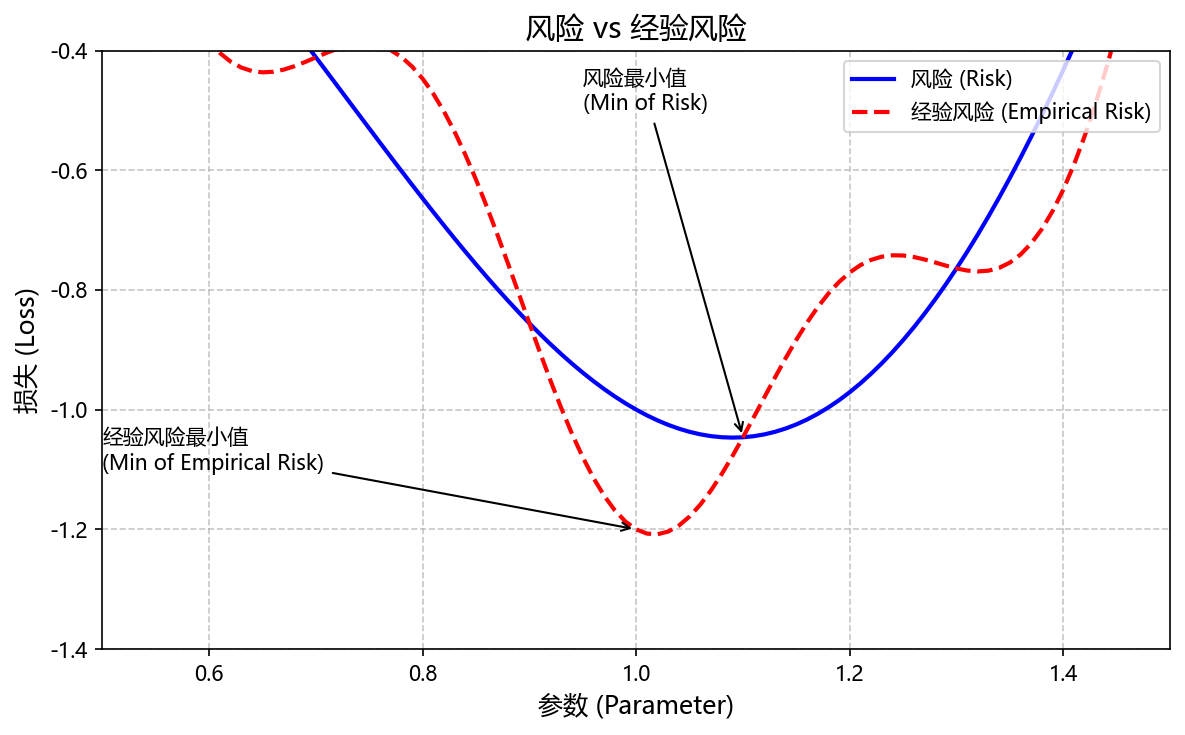

In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import rcParams

def f(x):
    return x * torch.cos(np.pi * x)

def g(x):
    return f(x) + 0.2 * torch.cos(5 * np.pi * x)

def annotate(text, xy, xytext):
    """添加箭头标注"""
    plt.annotate(text, xy=xy, xytext=xytext,
                 arrowprops=dict(arrowstyle='->', linewidth=1))

# 设置中文字体和图形参数
rcParams['font.sans-serif'] = ['Microsoft YaHei', 'Segoe UI Symbol', 'DejaVu Sans']
rcParams['axes.unicode_minus'] = False

# 创建数据
x = torch.arange(0.5, 1.5, 0.01)
f_values = f(x).numpy()
g_values = g(x).numpy()

# 绘制图形
fig, ax = plt.subplots(figsize=(8, 5))

# 绘制两条曲线
ax.plot(x.numpy(), f_values, 'b-', linewidth=2, label='风险 (Risk)')
ax.plot(x.numpy(), g_values, 'r--', linewidth=2, label='经验风险 (Empirical Risk)')

# 设置坐标轴标签
ax.set_xlabel('参数 (Parameter)', fontsize=12)
ax.set_ylabel('损失 (Loss)', fontsize=12)
ax.set_title('风险 vs 经验风险', fontsize=14)

# 添加图例
ax.legend(loc='upper right', fontsize=10)

# 添加网格
ax.grid(True, linestyle='--', alpha=0.7)

# 添加标注
annotate('经验风险最小值\n(Min of Empirical Risk)',
         (1.0, g_values[np.abs(x.numpy()-1.0).argmin()]),
         (0.5, -1.1))

annotate('风险最小值\n(Min of Risk)',
         (1.1, f_values[np.abs(x.numpy()-1.1).argmin()]),
         (0.95, -0.5))

# 设置坐标轴范围
ax.set_xlim(0.5, 1.5)
ax.set_ylim(-1.4, -0.4)

# 显示图形
plt.tight_layout()
plt.show()

### 深度学习中的优化挑战
- 关于解析解和数值解的理解：解析解就是可以直接公式（代数变换、微积分推导）推导出的精确解，可解释性强，数值解就是通过数值计算（迭代算法等）得到的近似解，深度学习中的神经网络损失函数就是用的数值解的方式，因为基本上在神经网络里面数据的维度都超级高，局部极小值一般也有无数个，没办法写出闭合的表达式，计算起来计算量大得不现实。
- 关于鞍点（梯度为零，伪装成极值点）的说法：就是像当前的损失走到了一个类似山脊的地方，左右走都能下降，但是前后走却不怎么变化（一般$\mathrm{SGD}$可能会被困在这附近，带动量的可以冲过鞍点区域，$\mathrm{Adam}$可以更好的逃离鞍点区域）。
- 海森矩阵：二阶导数矩阵，描述各个方向上的曲率，如下图（其中$n$就是多元函数的元数）,可通过海森矩阵的特征值的正负来判断是否是鞍点（目前其实不适用）。

![海森矩阵](../image/HessianMatrix.png)

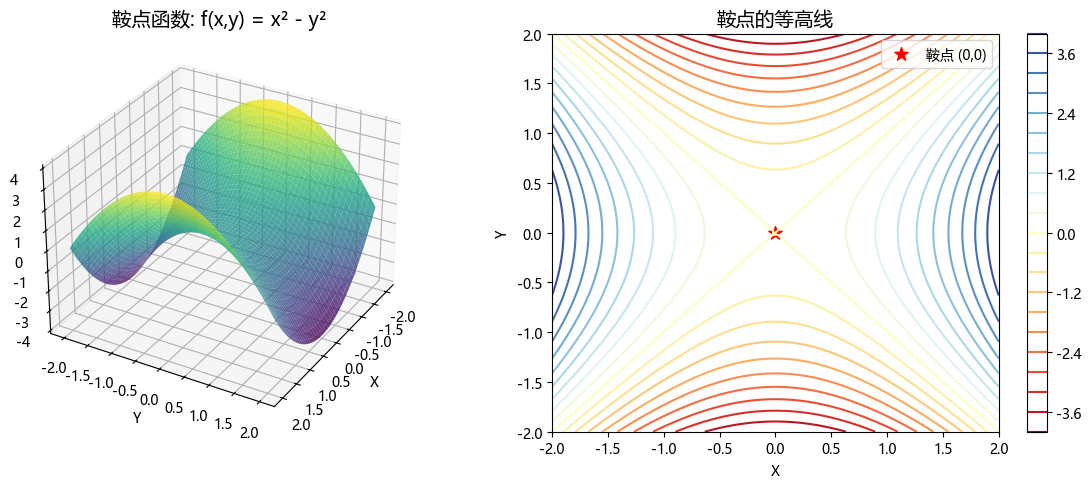

海森矩阵特征值: [ 2. -2.]
特征值一正一负 → 确认是鞍点！


In [3]:
# 定义经典的鞍点函数：f(x,y) = x^2 - y^2
def saddle_function(x, y):
    return x**2 - y**2

# 创建网格
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
Z = saddle_function(X, Y)

# 绘制3D曲面
fig = plt.figure(figsize=(12, 5))

# 3D图
ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, linewidth=0)
ax1.set_title('鞍点函数: f(x,y) = x² - y²', fontsize=14)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('f(x,y)')
ax1.view_init(30, 30)

# 等高线图
ax2 = fig.add_subplot(122)
contour = ax2.contour(X, Y, Z, 20, cmap='RdYlBu')
ax2.set_title('鞍点的等高线', fontsize=14)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
plt.colorbar(contour, ax=ax2)

# 标记鞍点(0,0)
ax2.scatter(0, 0, color='red', s=100, marker='*', label='鞍点 (0,0)')
ax2.legend()

plt.tight_layout()
plt.show()

# 计算海森矩阵特征值
H = np.array([[2, 0],  # ∂²f/∂x² = 2
              [0, -2]]) # ∂²f/∂y² = -2
eigenvalues = np.linalg.eigvals(H)
print(f"海森矩阵特征值: {eigenvalues}")
print("特征值一正一负 → 确认是鞍点！")

## 凸性
- 这个凸性的理论可以用来确认排除鞍点的影响（伪装）
- 凸集：就是一个“没有洞、没有凹陷”的集合（就像是这个集合所构建的一个几何图像，任意两点的连线都不会跑到图像外面去）。
- 凸函数：定义在凸集上的函数。
- 二者结合的凸优化理论可以创造一个没有陷阱（鞍点之类的）路径明确的优化地形，无论从哪里开始最终都能走到唯一的最低点（全局最优解）

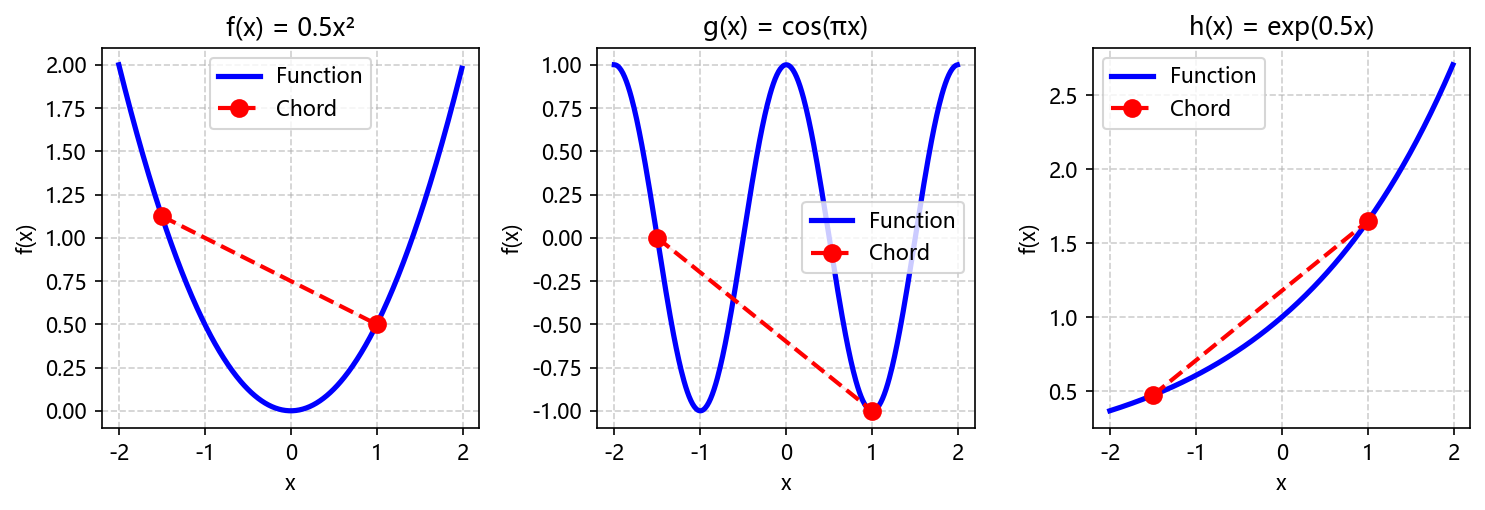

In [4]:
# 定义三个函数
f = lambda x: 0.5 * x**2  # 凸函数
g = lambda x: torch.cos(np.pi * x)  # 非凸函数
h = lambda x: torch.exp(0.5 * x)  # 凸函数

# 创建数据点
x = torch.arange(-2, 2, 0.01)
# 定义线段的两端点（用于连接演示凸性）
segment = torch.tensor([-1.5, 1])

# 设置图形输出为矢量图格式（可选，不影响显示）
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.format'] = 'svg'

# 创建1行3列的子图
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5))

# 为每个子图绘制对应的函数
for ax, func, title in zip(axes, [f, g, h], ['f(x) = 0.5x²', 'g(x) = cos(πx)', 'h(x) = exp(0.5x)']):
    # 绘制主函数曲线
    ax.plot(x.numpy(), func(x).numpy(), 'b-', linewidth=2.5, label='Function')

    # 计算并绘制连接线段（弦）
    segment_y = func(segment)
    ax.plot(segment.numpy(), segment_y.numpy(), 'r--o', linewidth=2, markersize=8, label='Chord')

    # 填充弦上方的区域，直观展示凸性：弦在函数曲线上方
    ax.fill_between(segment.numpy(),
                    segment_y.numpy(),
                    func(segment).numpy(),
                    color='red', alpha=0.1)

    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.set_title(title)
    ax.legend()

plt.tight_layout()
plt.show()

- 詹森不等式：就是说对于凸函数，函数的平均值 $\geqslant$ 平均值的函数
### 关于凸函数的性质
- 下述涉及到的理论在目前的应用是，在深度学习里面，整体的问题（网络）可能不具有凸性保证，但是目前是将这种凸性融入到网络的关键部分（比如激活函数、损失函数、正则化项这些部件；也就是在一个整体非凸的优化问题，在局部的强凸区域，优化算法可能已又很好的局部收敛保证）
- 在凸函数中，局部极小值就是全局极小值（这是凸函数的定义所带来的变化，对损失函数来说的话，“既然无法让整个地形（损失构成的空间）变成碗状（凸函数），那就确保关键路径是平滑的下坡，并沿途修建坚固的营地（局部凸区域）”，比如$\mathrm{ReLU}$激活函数，又比如损失函数在调整最后一层参数时，面对的是一个凸地形（就是最后一层输出的时候那个函数就是一个凸函数），正则化项（$L1、L2$范数本身就是凸的））
-下水平集：就是对一个函数和一个实数来说，这个函数的函数值不超过该实数的点构成的集合就是它们的下水平集（对一个凸函数，它的任何一个“等高线下方的区域”形状都是“饱满的”，没有凹陷）
- 海森矩阵就是多元函数的二阶导数组合成的（和数学一样利用二阶导数来判断函数的凹凸性）
### 约束
- 约束优化问题可转换为拉格朗日函数的鞍点优化问题（拉格朗日函数的鞍点就是原始约束优化问题的最优解）。
- 惩罚：就是构造一个惩罚函数，当优化结果超出约束条件时会使用惩罚系数，让其趋于无穷大来让模型判断其结果不可接受使其解逼近原约束问题的解（拉格朗日函数里面的那个系数就是这个惩罚系数的意思）。
- 投影：就是在迭代算法（梯度下降）的过程中，某一步不在约束内了，就使用投影的方法（到约束域的投影）找到在约束域且离其最近的点（这个过程的复杂性取决于约束域的形状）。

## 梯度下降
- 就是 原参数-(学习率乘以损失函数对该参数的偏导数)=更新后的参数
### 一维梯度下降
- 就是优化变量只有一个的梯度下降方法

梯度下降轨迹: [10.0, 6.0, 3.5999999999999996, 2.1599999999999997, 1.2959999999999998, 0.7775999999999998, 0.46655999999999986, 0.2799359999999999, 0.16796159999999993, 0.10077695999999996, 0.06046617599999997]
最终值: x = 0.0605, f(x) = 0.0037


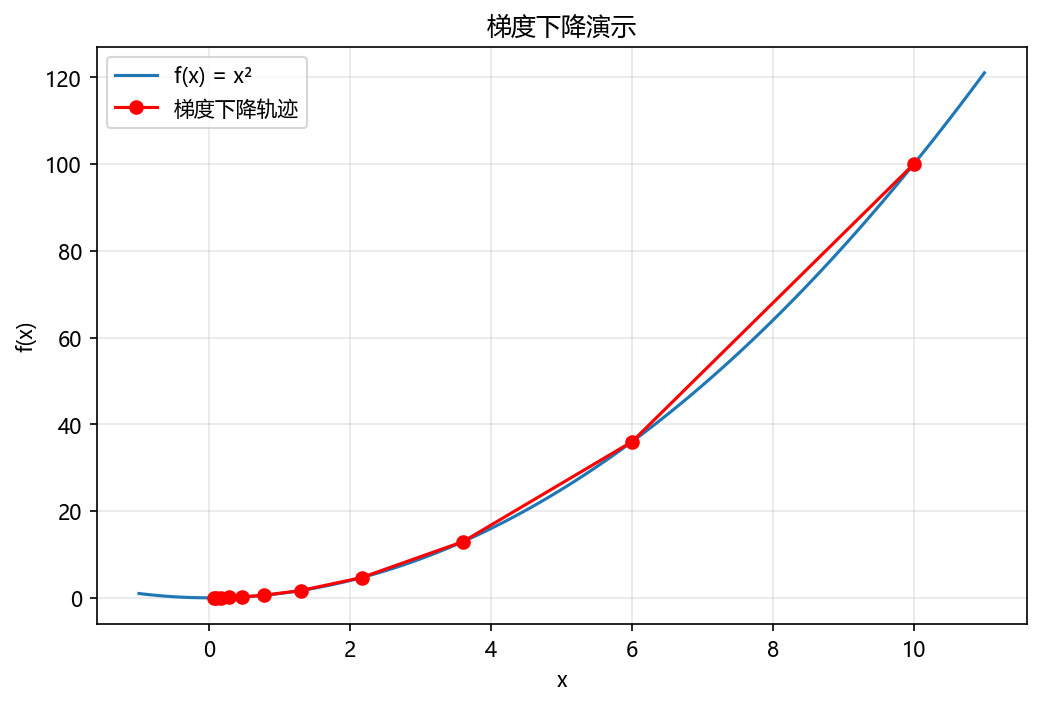

In [5]:
# 定义函数和梯度
def f(x):
    return x ** 2

def f_grad(x):
    return 2 * x

# 梯度下降算法
def gd(eta, f_grad, steps=10):
    x = 10.0
    results = [x]
    for i in range(steps):
        x -= eta * f_grad(x)
        results.append(x)
    return results

# 可视化函数
def show_trace(results, f):
    x_vals = np.linspace(-1, 11, 100)

    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, f(x_vals), label='f(x) = x²')
    plt.plot(results, [f(x) for x in results], 'ro-', label='梯度下降轨迹')

    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title('梯度下降演示')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# 运行和显示
results = gd(0.2, f_grad, 10)
print(f"梯度下降轨迹: {results}")
print(f"最终值: x = {results[-1]:.4f}, f(x) = {f(results[-1]):.4f}")
show_trace(results, f)

- 学习率：就是控制梯度更新速度的参数。

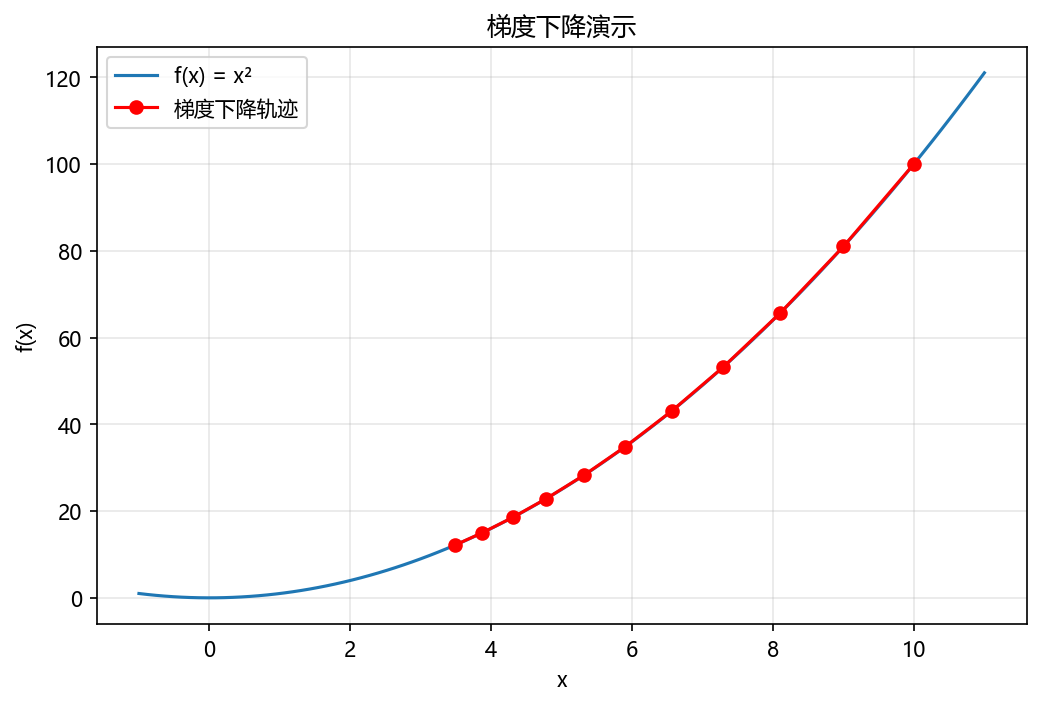

In [6]:
# 只运行学习率为0.05的情况
eta = 0.05
results = gd(eta, f_grad, 10)
show_trace(results, f)

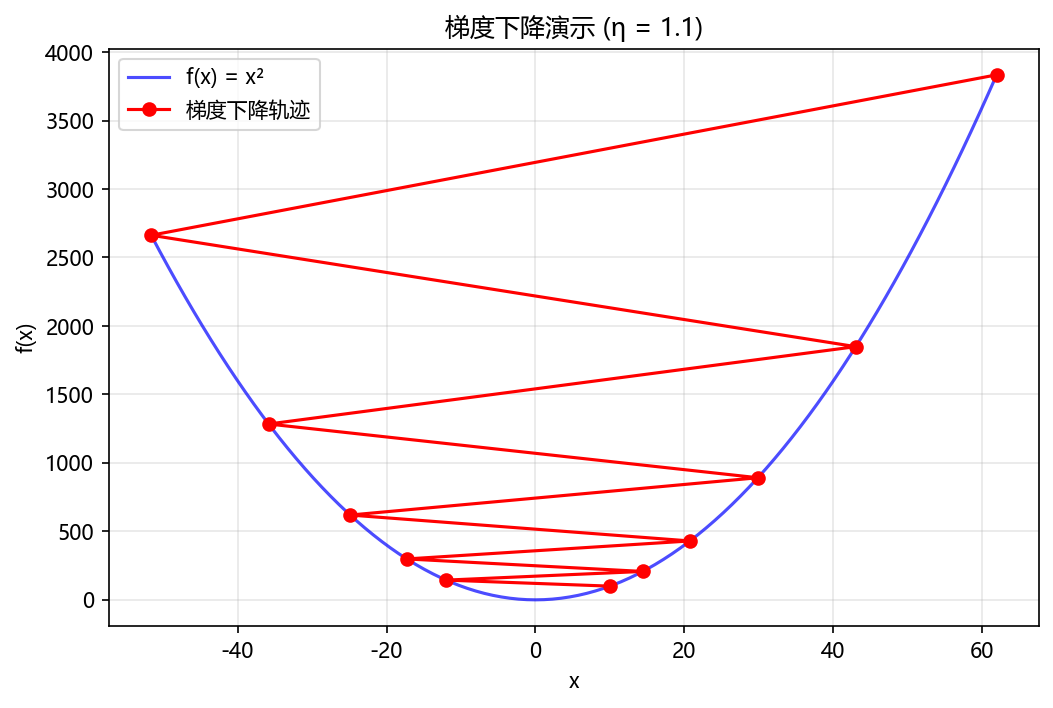

学习率 η = 1.1
轨迹: [10.0, -12.0, 14.4, -17.28, 20.736, -24.8832, 29.8598, -35.8318, 42.9982, -51.5978, 61.9174]
最终: x = 61.9174, f(x) = 3833.7600


In [7]:
# 定义函数和梯度
f = lambda x: x**2
f_grad = lambda x: 2*x

# 梯度下降算法（返回一个元组）
def gd(eta, f_grad, steps=10):
    x = 10.0
    results = [x]
    for i in range(steps):
        x -= eta * f_grad(x)
        results.append(x)
    return results, eta

# 可视化函数（接受元组）
def show_trace(gd_result, f):
    results, eta = gd_result
    x_vals = np.linspace(min(min(results), -2), max(max(results), 2), 100)

    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, f(x_vals), 'b-', label='f(x) = x²', alpha=0.7)
    plt.plot(results, [f(x) for x in results], 'ro-', label='梯度下降轨迹', markersize=6)

    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title(f'梯度下降演示 (η = {eta})')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    print(f"学习率 η = {eta}")
    print(f"轨迹: {[round(x, 4) for x in results]}")
    print(f"最终: x = {results[-1]:.4f}, f(x) = {f(results[-1]):.4f}")

# 直接调用 show_trace(gd(1.1, f_grad), f)
show_trace(gd(1.1, f_grad), f)

- 局部最小值：高学习率有时候会导致函数到一个局部的最小值

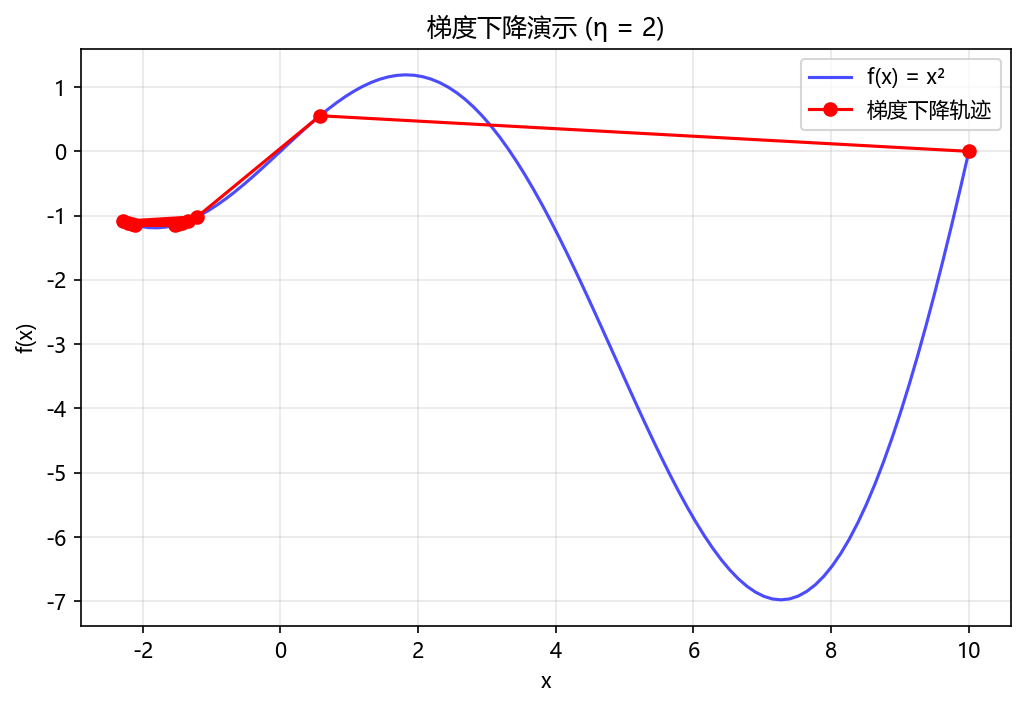

学习率 η = 2
轨迹: [10.0, np.float64(0.5752), np.float64(-1.2066), np.float64(-2.2796), np.float64(-1.3434), np.float64(-2.2068), np.float64(-1.4258), np.float64(-2.1546), np.float64(-1.4839), np.float64(-2.1144), np.float64(-1.5282)]
最终: x = -1.5282, f(x) = -1.1488


In [8]:
# 定义常数 c
c = 0.15 * np.pi

# 定义目标函数和梯度
def f(x):
    return x * np.cos(c * x)

def f_grad(x):
    return np.cos(c * x) - c * x * np.sin(c * x)

show_trace(gd(2, f_grad), f)

### 多元梯度下降
- 核心的东西都和一维梯度下降是一致的，就是把单个偏导，变成偏导矩阵来操作了。

迭代 1, x1: -4.000000, x2: -1.200000
迭代 2, x1: -3.200000, x2: -0.720000
迭代 3, x1: -2.560000, x2: -0.432000
迭代 4, x1: -2.048000, x2: -0.259200
迭代 5, x1: -1.638400, x2: -0.155520
迭代 6, x1: -1.310720, x2: -0.093312
迭代 7, x1: -1.048576, x2: -0.055987
迭代 8, x1: -0.838861, x2: -0.033592
迭代 9, x1: -0.671089, x2: -0.020155
迭代 10, x1: -0.536871, x2: -0.012093
迭代 11, x1: -0.429497, x2: -0.007256
迭代 12, x1: -0.343597, x2: -0.004354
迭代 13, x1: -0.274878, x2: -0.002612
迭代 14, x1: -0.219902, x2: -0.001567
迭代 15, x1: -0.175922, x2: -0.000940
迭代 16, x1: -0.140737, x2: -0.000564
迭代 17, x1: -0.112590, x2: -0.000339
迭代 18, x1: -0.090072, x2: -0.000203
迭代 19, x1: -0.072058, x2: -0.000122
迭代 20, x1: -0.057646, x2: -0.000073


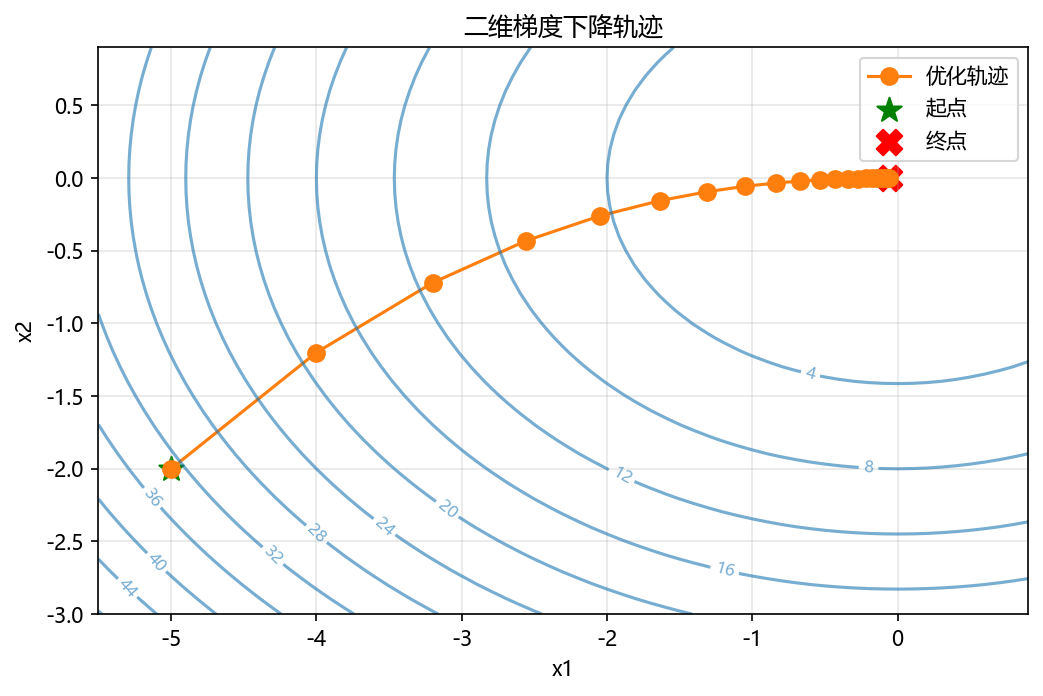

In [9]:
def train_2d(trainer, steps=20, f_grad=None):
    """用定制的训练机优化2D目标函数"""
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]

    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
        print(f'迭代 {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')

    return results

def show_trace_2d(f, results):
    """显示优化过程中2D变量的轨迹"""
    plt.figure(figsize=(8, 6))

    # 解压轨迹坐标
    x1_vals, x2_vals = zip(*results)
    plt.plot(x1_vals, x2_vals, '-o', color='#ff7f0e', markersize=8, label='优化轨迹')

    # 绘制起点和终点
    plt.scatter(x1_vals[0], x2_vals[0], color='green', s=150, marker='*', label='起点')
    plt.scatter(x1_vals[-1], x2_vals[-1], color='red', s=150, marker='X', label='终点')

    # 创建等高线网格
    x1_grid, x2_grid = np.meshgrid(
        np.arange(-5.5, 1.0, 0.1),
        np.arange(-3.0, 1.0, 0.1),
        indexing='ij'
    )

    # 计算函数值
    f_vals = f(x1_grid, x2_grid)

    # 绘制等高线
    contour = plt.contour(x1_grid, x2_grid, f_vals, levels=15, colors='#1f77b4', alpha=0.6)
    plt.clabel(contour, inline=True, fontsize=8)

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('二维梯度下降轨迹')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # 调整坐标轴比例，使等高线显示为正圆
    plt.gca().set_aspect('equal', adjustable='box')

    plt.show()

# 定义二维目标函数
def f_2d(x1, x2):
    """目标函数: f(x1, x2) = x1^2 + 2*x2^2"""
    return x1 ** 2 + 2 * x2 ** 2

def f_2d_grad(x1, x2):
    """目标函数的梯度"""
    return (2 * x1, 4 * x2)

def gd_2d(x1, x2, s1, s2, f_grad):
    """二维梯度下降更新"""
    g1, g2 = f_grad(x1, x2)
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)

# 设置学习率并运行
eta = 0.1
results = train_2d(gd_2d, f_grad=f_2d_grad)
show_trace_2d(f_2d, results)

### 自适应方法
- 牛顿法：就是使用泰勒展开来进行求导等计算。

迭代10次后, x: 0.0


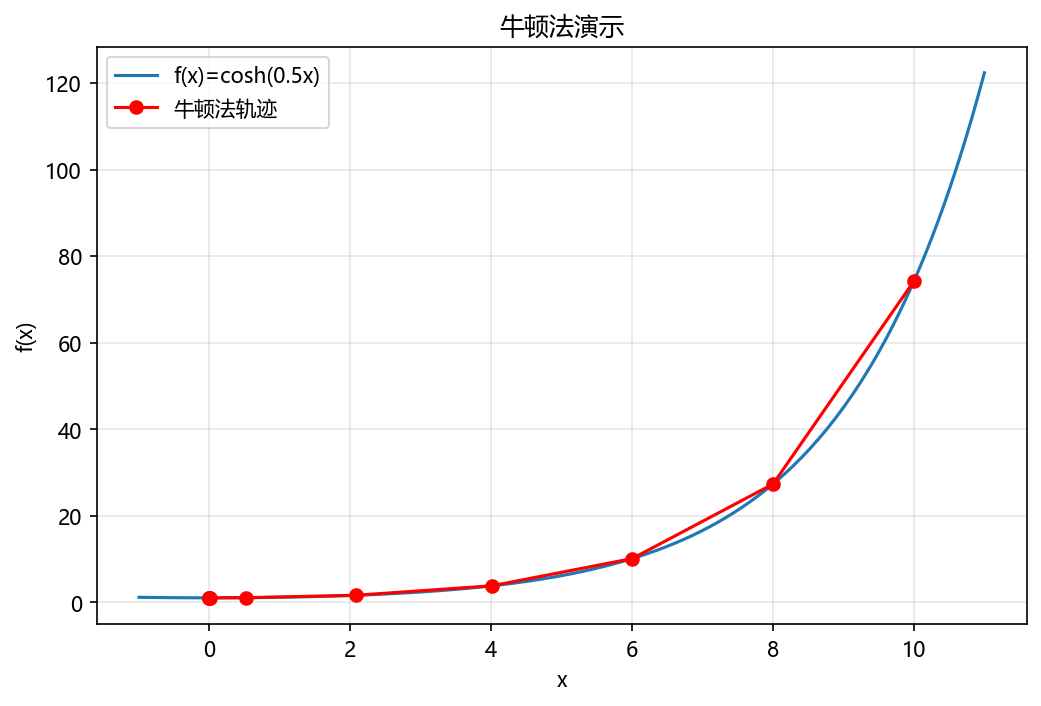

轨迹: [10.0, np.float64(8.0002), np.float64(6.0015), np.float64(4.0114), np.float64(2.0825), np.float64(0.5258), np.float64(0.0118), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]


In [10]:
# 定义常数 c
c = 0.5

# 定义目标函数及其导数
def f(x):
    return np.cosh(c * x)

def f_grad(x):
    return c * np.sinh(c * x)

def f_hess(x):
    return c**2 * np.cosh(c * x)

# 牛顿法
def newton(eta=1):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x) / f_hess(x)
        results.append(x)
    print('迭代10次后, x:', x)
    return results

# 可视化
def show_trace(results, f):
    x_vals = np.linspace(min(results)-1, max(results)+1, 200)

    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, f(x_vals), label=f'f(x)=cosh({c}x)')
    plt.plot(results, [f(x) for x in results], 'ro-', label='牛顿法轨迹')

    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title('牛顿法演示')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    print(f"轨迹: {[round(x, 4) for x in results]}")

# 运行
results = newton(eta=1)
show_trace(results, f)

迭代10次后, x: 1.825685, f(x): 1.190683


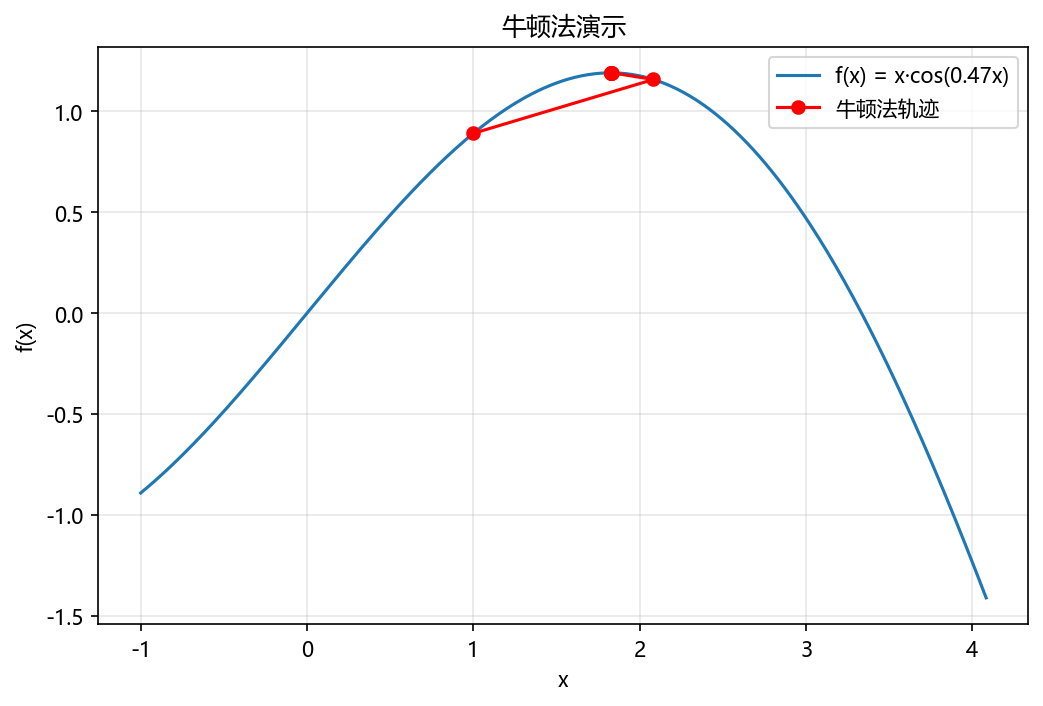

轨迹: [1.0, np.float64(2.082), np.float64(1.8327), np.float64(1.8257), np.float64(1.8257), np.float64(1.8257), np.float64(1.8257), np.float64(1.8257), np.float64(1.8257), np.float64(1.8257), np.float64(1.8257)]


In [11]:
# 定义常数 c
c = 0.15 * np.pi

# 定义目标函数及其导数
def f(x):
    return x * np.cos(c * x)

def f_grad(x):
    return np.cos(c * x) - c * x * np.sin(c * x)

def f_hess(x):
    return - 2 * c * np.sin(c * x) - x * c**2 * np.cos(c * x)

# 牛顿法
def newton(eta=1):
    x = 1.0  # 注意：这个函数在x=10处梯度极大，可能会发散，所以改为1.0
    results = [x]
    for i in range(10):
        # 牛顿法更新：x = x - η * f'(x) / f''(x)
        # 防止除零错误
        hess = f_hess(x)
        if abs(hess) < 1e-12:
            hess = 1e-12 if hess >= 0 else -1e-12
        x -= eta * f_grad(x) / hess
        results.append(x)
    print(f'迭代10次后, x: {x:.6f}, f(x): {f(x):.6f}')
    return results

# 可视化
def show_trace(results, f):
    x_vals = np.linspace(min(results)-2, max(results)+2, 400)

    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, f(x_vals), label=f'f(x) = x·cos({c:.2f}x)')
    plt.plot(results, [f(x) for x in results], 'ro-', label='牛顿法轨迹')

    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title('牛顿法演示')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    print(f"轨迹: {[round(x, 4) for x in results]}")

# 运行
results = newton(eta=1)
show_trace(results, f)

- 关于牛顿法的弊端就是，计算成本高，随着优化步骤的增加，损失可能会上升，容易收敛到极大值点或者鞍点。但在凸问题中好用。
## 随机梯度下降
- 就是从开始是整个数据集的样本都计算梯度来更新参数，变成每次迭代都只随机选一个样本来计算梯度更新索引。从原始定义来看随机梯度是完整梯度的一个无偏估计（平均的来看）
### 随机梯度更新

epoch 1, x1: -4.128078, x2: -1.189627
epoch 2, x1: -3.285695, x2: -0.704894
epoch 3, x1: -2.587020, x2: -0.349126
epoch 4, x1: -1.905604, x2: -0.043838
epoch 5, x1: -1.451214, x2: 0.021797
epoch 6, x1: -0.939835, x2: -0.167070
epoch 7, x1: -0.516135, x2: -0.087744
epoch 8, x1: -0.422979, x2: 0.048464
epoch 9, x1: -0.285312, x2: -0.243367
epoch 10, x1: -0.153145, x2: -0.214822
epoch 11, x1: -0.129555, x2: -0.242872
epoch 12, x1: -0.120841, x2: -0.130349
epoch 13, x1: -0.142522, x2: -0.114272
epoch 14, x1: -0.063313, x2: -0.108060
epoch 15, x1: -0.260376, x2: -0.210586
epoch 16, x1: -0.199871, x2: -0.014324
epoch 17, x1: -0.092818, x2: -0.015363
epoch 18, x1: -0.028182, x2: -0.069540
epoch 19, x1: 0.028859, x2: 0.040272
epoch 20, x1: 0.245104, x2: 0.128031
epoch 21, x1: 0.247222, x2: 0.023330
epoch 22, x1: 0.105397, x2: -0.042824
epoch 23, x1: 0.035376, x2: -0.038451
epoch 24, x1: 0.029948, x2: -0.082287
epoch 25, x1: -0.197839, x2: -0.030354
epoch 26, x1: -0.285929, x2: -0.028846
epoch 

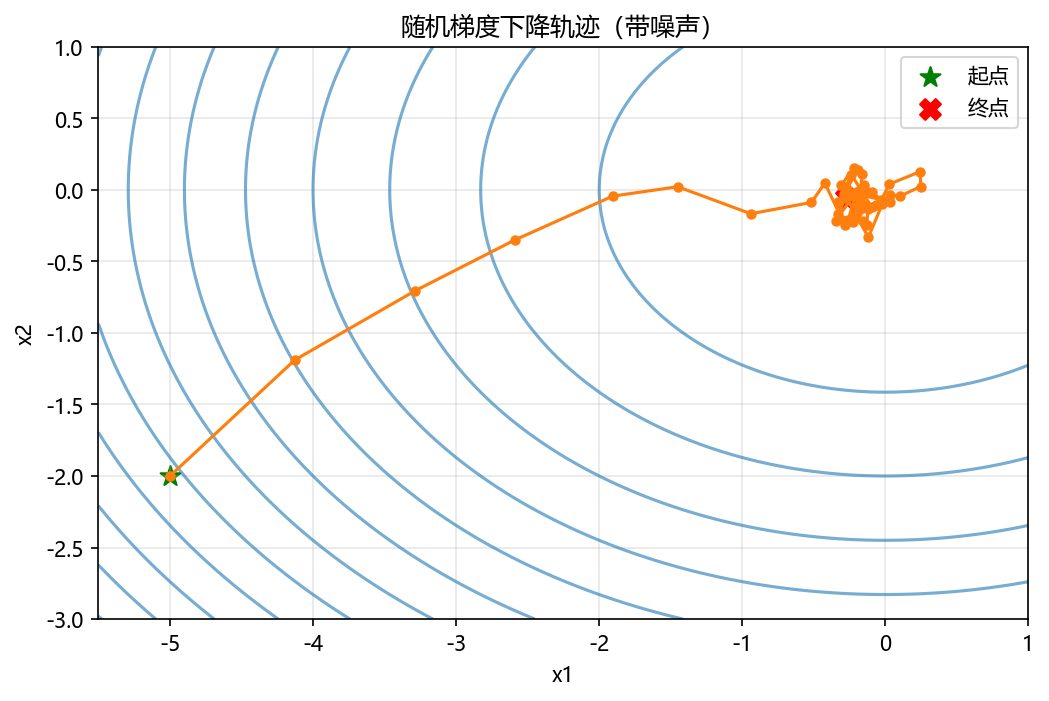

In [12]:
# 目标函数及其梯度
def f(x1, x2):
    return x1 ** 2 + 2 * x2 ** 2

def f_grad(x1, x2):
    return 2 * x1, 4 * x2

# 常数学习率函数
def constant_lr():
    return 1

# 随机梯度下降（带噪声）
def sgd(x1, x2, s1, s2, f_grad, eta=0.1, lr_func=constant_lr):
    g1, g2 = f_grad(x1, x2)

    # 添加随机噪声到梯度
    g1 += np.random.normal(0.0, 1)
    g2 += np.random.normal(0.0, 1)

    eta_t = eta * lr_func()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

# 训练函数（2D）
def train_2d(trainer, steps=50, f_grad=None):
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]

    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
        print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')

    return results

# 可视化函数（2D）
def show_trace_2d(f, results):
    # 解包轨迹坐标
    x1_vals, x2_vals = zip(*results)

    # 创建等高线网格
    x1_grid, x2_grid = np.meshgrid(
        np.linspace(-5.5, 1.0, 100),
        np.linspace(-3.0, 1.0, 100)
    )

    # 计算函数值
    f_vals = f(x1_grid, x2_grid)

    plt.figure(figsize=(8, 6))

    # 绘制等高线
    plt.contour(x1_grid, x2_grid, f_vals, levels=15, colors='#1f77b4', alpha=0.6)

    # 绘制轨迹
    plt.plot(x1_vals, x2_vals, '-o', color='#ff7f0e', markersize=4, linewidth=1.5)

    # 标记起点和终点
    plt.scatter(x1_vals[0], x2_vals[0], color='green', s=100, marker='*', label='起点')
    plt.scatter(x1_vals[-1], x2_vals[-1], color='red', s=100, marker='X', label='终点')

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('随机梯度下降轨迹（带噪声）')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')

    plt.show()

# 运行
eta = 0.1
lr = constant_lr

# 训练并显示轨迹
results = train_2d(lambda x1, x2, s1, s2, f_grad: sgd(x1, x2, s1, s2, f_grad, eta, lr),
                   steps=50, f_grad=f_grad)
show_trace_2d(f, results)

- 虽然可以帮助跳出局部最小值点，但是花的优化步数比较长，并且最终的结果不稳定，需要更精细的学习率的调整
### 动态学习率
- 动态学习率的使用就是为了更好的适应在训练过程中不同阶段的特性
- 其核心就是：在训练初期的时候，使用一个较大的学习率来快速的脱离局部最优，中期的时候适中的学习率来稳定收敛，最后的时候使用小学习率来做精细的调整以此来接近最优解
-

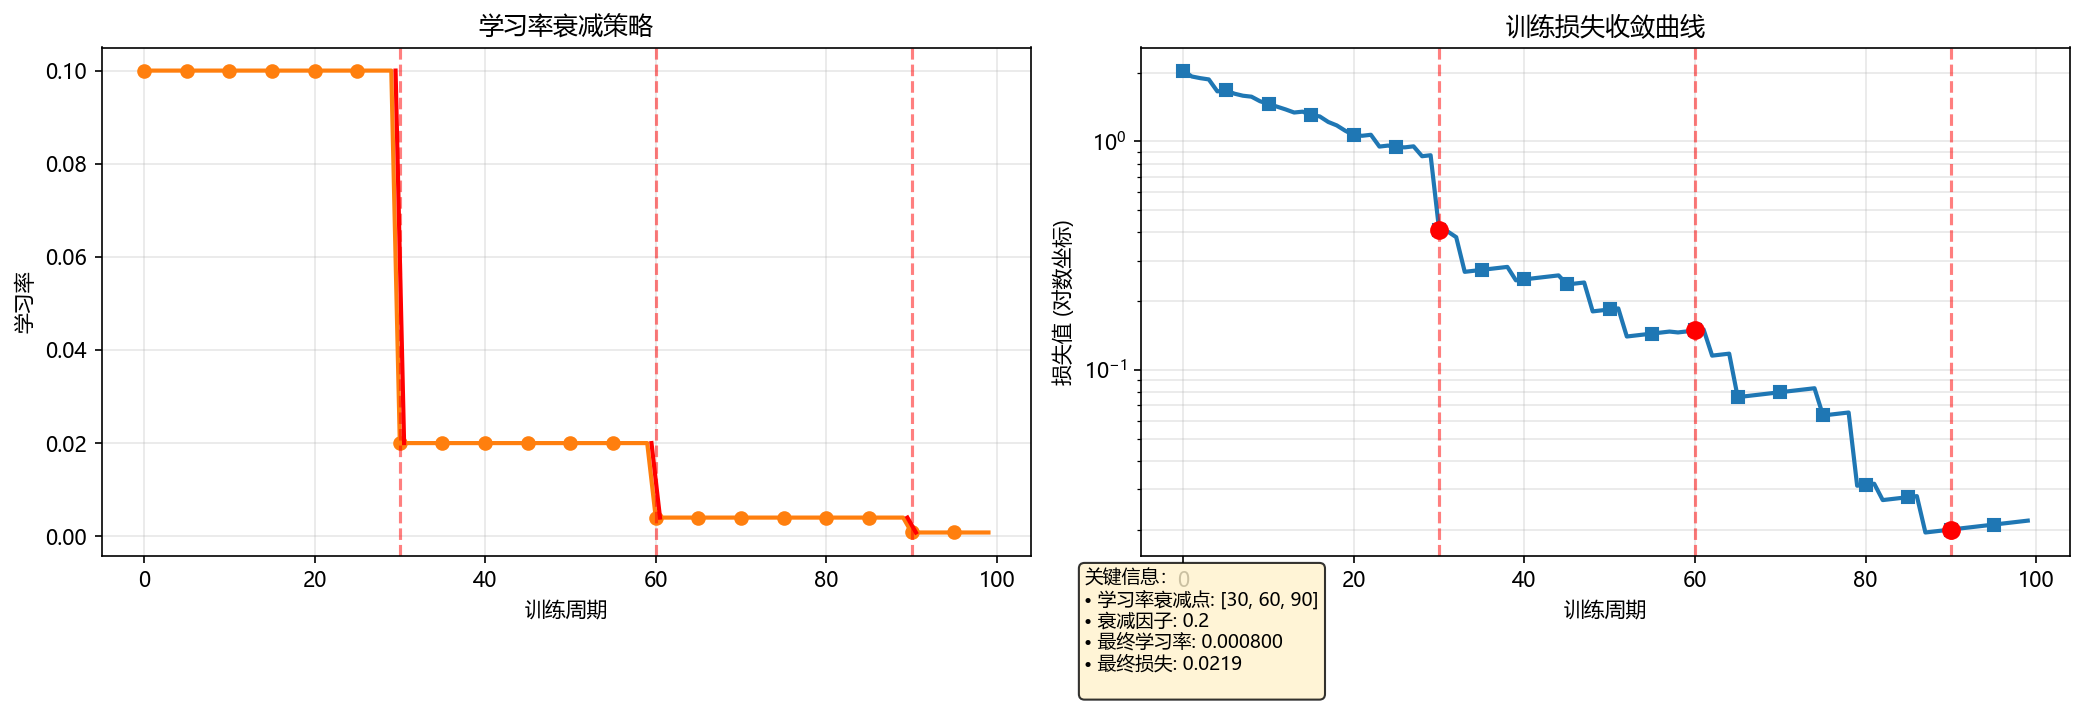

In [23]:
# 参数设置
initial_lr, min_lr = 0.1, 0.0001
epochs = np.arange(100)
drop_epochs, drop_rate = [30, 60, 90], 0.2

# 学习率计算函数
def step_decay(epoch):
    lr = initial_lr
    for drop in drop_epochs:
        if epoch >= drop:
            lr *= drop_rate
    return max(lr, min_lr)

lr_values = [step_decay(e) for e in epochs]

# 模拟损失函数
def simulate_loss(lr_values):
    losses = []
    base_loss = 2.0
    for i, (epoch, lr) in enumerate(zip(epochs, lr_values)):
        decay = np.exp(-epoch * 0.03)
        lr_effect = 0.5 * np.exp(-(lr - 0.01)**2 / 0.002) + 0.5
        current_loss = base_loss * decay * (1.5 - lr_effect) + np.random.normal(0, 0.05)
        current_loss = min(current_loss, losses[-1] * 1.01) if i > 0 else current_loss
        losses.append(max(current_loss, 0.01))
    return np.array(losses)

losses = simulate_loss(lr_values)

# 创建图表
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：学习率衰减曲线
axes[0].plot(epochs, lr_values, 'o-', markevery=5, linewidth=2, color='#FF7F0E')
for drop in drop_epochs:
    axes[0].axvline(x=drop, color='red', linestyle='--', alpha=0.5)
    lr_before, lr_after = step_decay(drop-1), step_decay(drop)
    axes[0].plot([drop-0.5, drop+0.5], [lr_before, lr_after], 'r-', linewidth=2)
axes[0].set(xlabel='训练周期', ylabel='学习率', title='学习率衰减策略')
axes[0].grid(True, alpha=0.3)

# 右图：损失收敛曲线
axes[1].semilogy(epochs, losses, 's-', markevery=5, linewidth=2, color='#1F77B4')
for drop in drop_epochs:
    axes[1].axvline(x=drop, color='red', linestyle='--', alpha=0.5)
    axes[1].plot(drop, losses[drop], 'ro', markersize=8)
axes[1].set(xlabel='训练周期', ylabel='损失值 (对数坐标)', title='训练损失收敛曲线')
axes[1].grid(True, alpha=0.3, which='both')

# 添加关键信息
info_text = f"""关键信息：
• 学习率衰减点: {drop_epochs}
• 衰减因子: {drop_rate}
• 最终学习率: {lr_values[-1]:.6f}
• 最终损失: {losses[-1]:.4f}
"""
plt.figtext(0.52, 0.02, info_text, fontsize=9,
            bbox=dict(boxstyle='round', facecolor='#FFF2CC', alpha=0.8))

plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()

C:\Users\DaiYongle\AppData\Local\Temp\ipykernel_50900\3416567971.py:62: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Microsoft YaHei.
  plt.tight_layout()
D:\anaconda3\envs\DLL\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Microsoft YaHei.
  fig.canvas.print_figure(bytes_io, **kw)


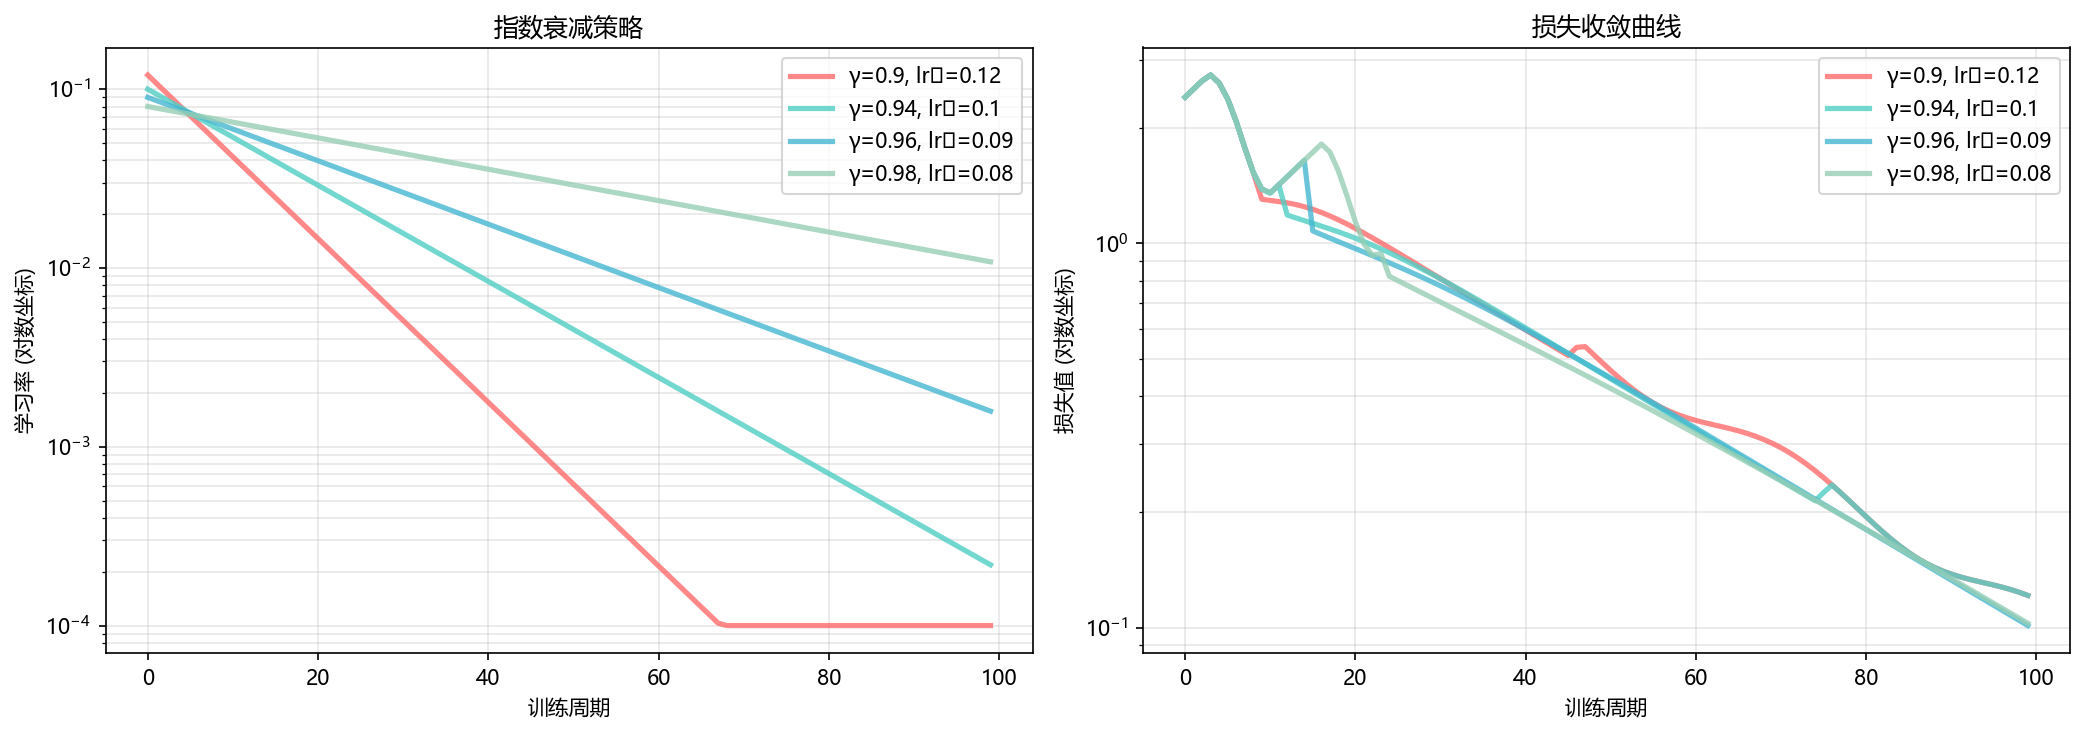

In [29]:
# 参数设置
epochs = np.arange(100)
decay_rates = [0.9, 0.94, 0.96, 0.98]
initial_lrs = [0.12, 0.1, 0.09, 0.08]  # 不同衰减率的初始学习率
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# 指数衰减函数
def exponential_decay(epoch, decay_rate, init_lr):
    return max(init_lr * (decay_rate ** epoch), 0.0001)

# 模拟损失函数
def simulate_loss(lr_vals):
    losses = []
    base_loss = 2.0

    for i, (epoch, lr) in enumerate(zip(epochs, lr_vals)):
        base_decay = np.exp(-epoch * 0.03)

        if lr > 0.05:
            lr_penalty = 1.2 + 0.3 * np.sin(epoch * 0.5)
        elif lr < 0.001:
            lr_penalty = 1.1 + 0.1 * np.sin(epoch * 0.2)
        else:
            lr_penalty = 0.8 + 0.2 * np.exp(-(lr - 0.01)**2 / 0.001)

        current_loss = base_loss * base_decay * lr_penalty

        if i > 0:
            current_loss = min(current_loss, losses[-1] * 1.05)

        losses.append(max(current_loss, 0.01))

    return np.array(losses)

# 创建图表
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：学习率衰减策略
for dr, init_lr, color in zip(decay_rates, initial_lrs, colors):
    lr_vals = [exponential_decay(e, dr, init_lr) for e in epochs]
    axes[0].semilogy(epochs, lr_vals, linewidth=2.5, alpha=0.8,
                    label=f'γ={dr}, lr₀={init_lr}', color=color)

axes[0].set(xlabel='训练周期', ylabel='学习率 (对数坐标)', title='指数衰减策略')
axes[0].grid(True, alpha=0.3, which='both')
axes[0].legend(loc='upper right')

# 右图：损失收敛曲线
for dr, init_lr, color in zip(decay_rates, initial_lrs, colors):
    lr_vals = [exponential_decay(e, dr, init_lr) for e in epochs]
    losses = simulate_loss(lr_vals)
    axes[1].semilogy(epochs, losses, linewidth=2.5, alpha=0.8,
                    label=f'γ={dr}, lr₀={init_lr}', color=color)

axes[1].set(xlabel='训练周期', ylabel='损失值 (对数坐标)', title='损失收敛曲线')
axes[1].grid(True, alpha=0.3, which='both')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

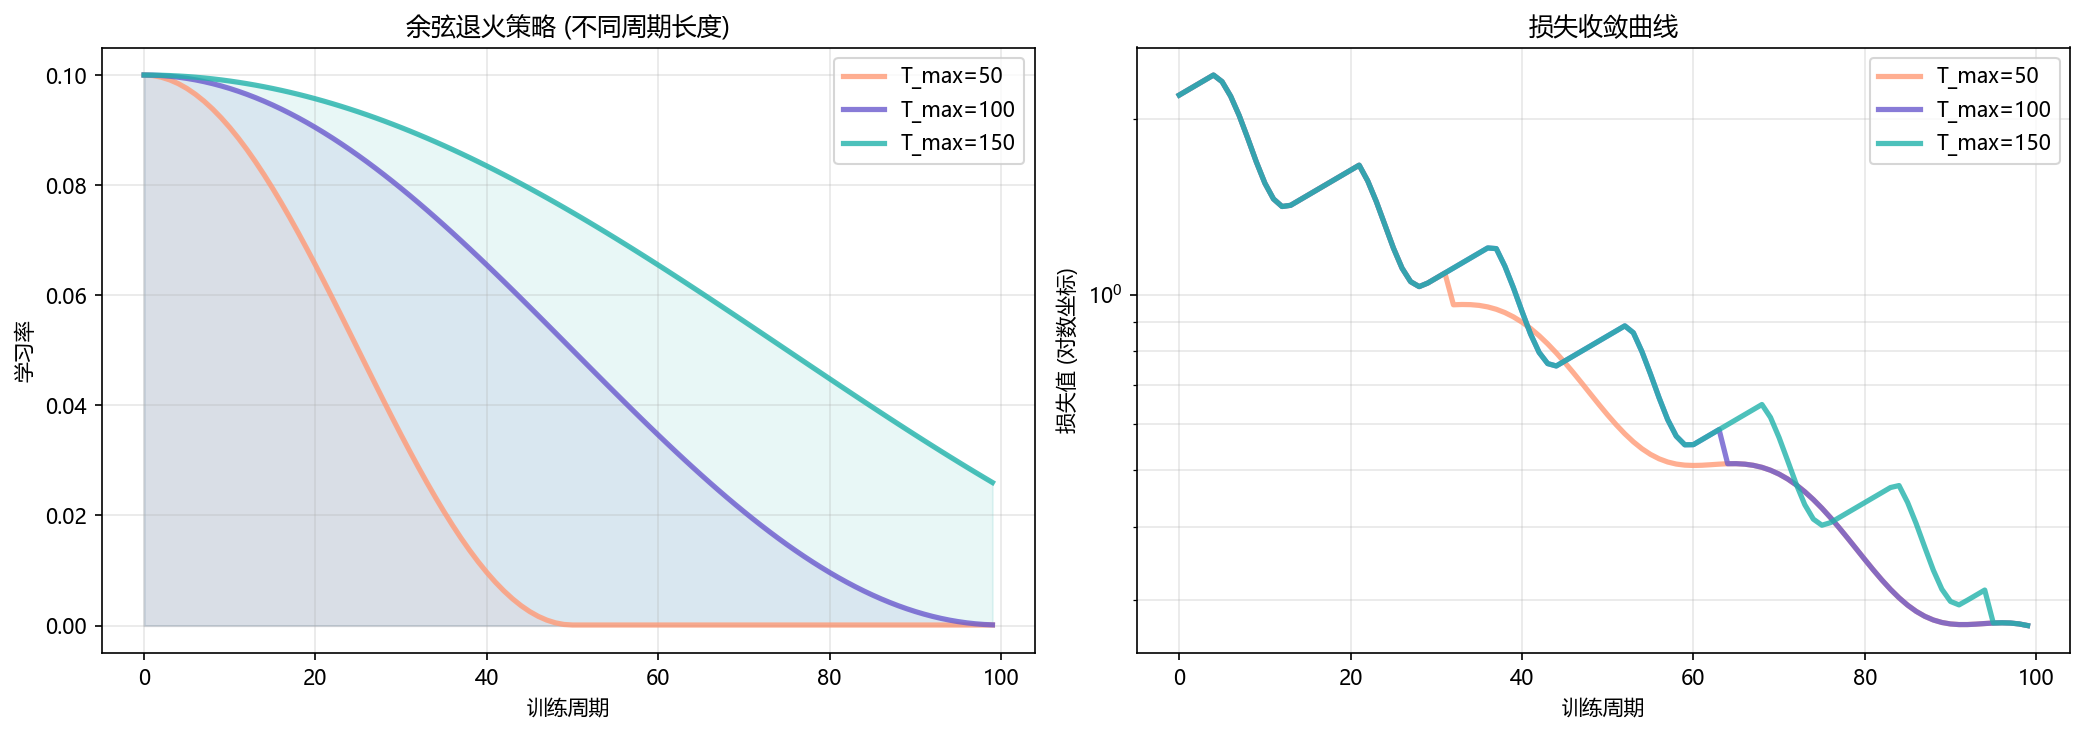

In [30]:
# 参数设置
initial_lr = 0.1
epochs = np.arange(100)

# 余弦退火函数
def cosine_decay(epoch, T_max=100, eta_min=0.0001):
    if epoch >= T_max:
        return eta_min
    cosine = 0.5 * (1 + np.cos(np.pi * epoch / T_max))
    lr = eta_min + (initial_lr - eta_min) * cosine
    return lr

# 计算不同周期长度的余弦退火
T_values = [50, 100, 150]
colors = ['#FF9A76', '#6A5ACD', '#20B2AA']

# 模拟损失函数
def simulate_loss(lr_vals):
    losses = []
    base_loss = 2.0

    for i, (epoch, lr) in enumerate(zip(epochs, lr_vals)):
        base_decay = np.exp(-epoch * 0.02)

        if lr > 0.03:  # 学习率较大时
            lr_penalty = 1.1 + 0.2 * np.sin(epoch * 0.4)
        else:  # 学习率较小时
            lr_penalty = 0.9 + 0.1 * np.sin(epoch * 0.2)

        current_loss = base_loss * base_decay * lr_penalty

        if i > 0:
            current_loss = min(current_loss, losses[-1] * 1.02)

        losses.append(max(current_loss, 0.01))

    return np.array(losses)

# 创建图表
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：不同周期长度的余弦退火策略
for T, color in zip(T_values, colors):
    lr_vals = [cosine_decay(e, T_max=T) for e in epochs]
    axes[0].plot(epochs, lr_vals, linewidth=2.5, alpha=0.8,
                label=f'T_max={T}', color=color)
    axes[0].fill_between(epochs, lr_vals, alpha=0.1, color=color)

axes[0].set_xlabel('训练周期')
axes[0].set_ylabel('学习率')
axes[0].set_title('余弦退火策略 (不同周期长度)')
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='upper right')

# 右图：对应的损失收敛曲线
for T, color in zip(T_values, colors):
    lr_vals = [cosine_decay(e, T_max=T) for e in epochs]
    losses = simulate_loss(lr_vals)
    axes[1].semilogy(epochs, losses, linewidth=2.5, alpha=0.8,
                    label=f'T_max={T}', color=color)

axes[1].set_xlabel('训练周期')
axes[1].set_ylabel('损失值 (对数坐标)')
axes[1].set_title('损失收敛曲线')
axes[1].grid(True, alpha=0.3, which='both')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

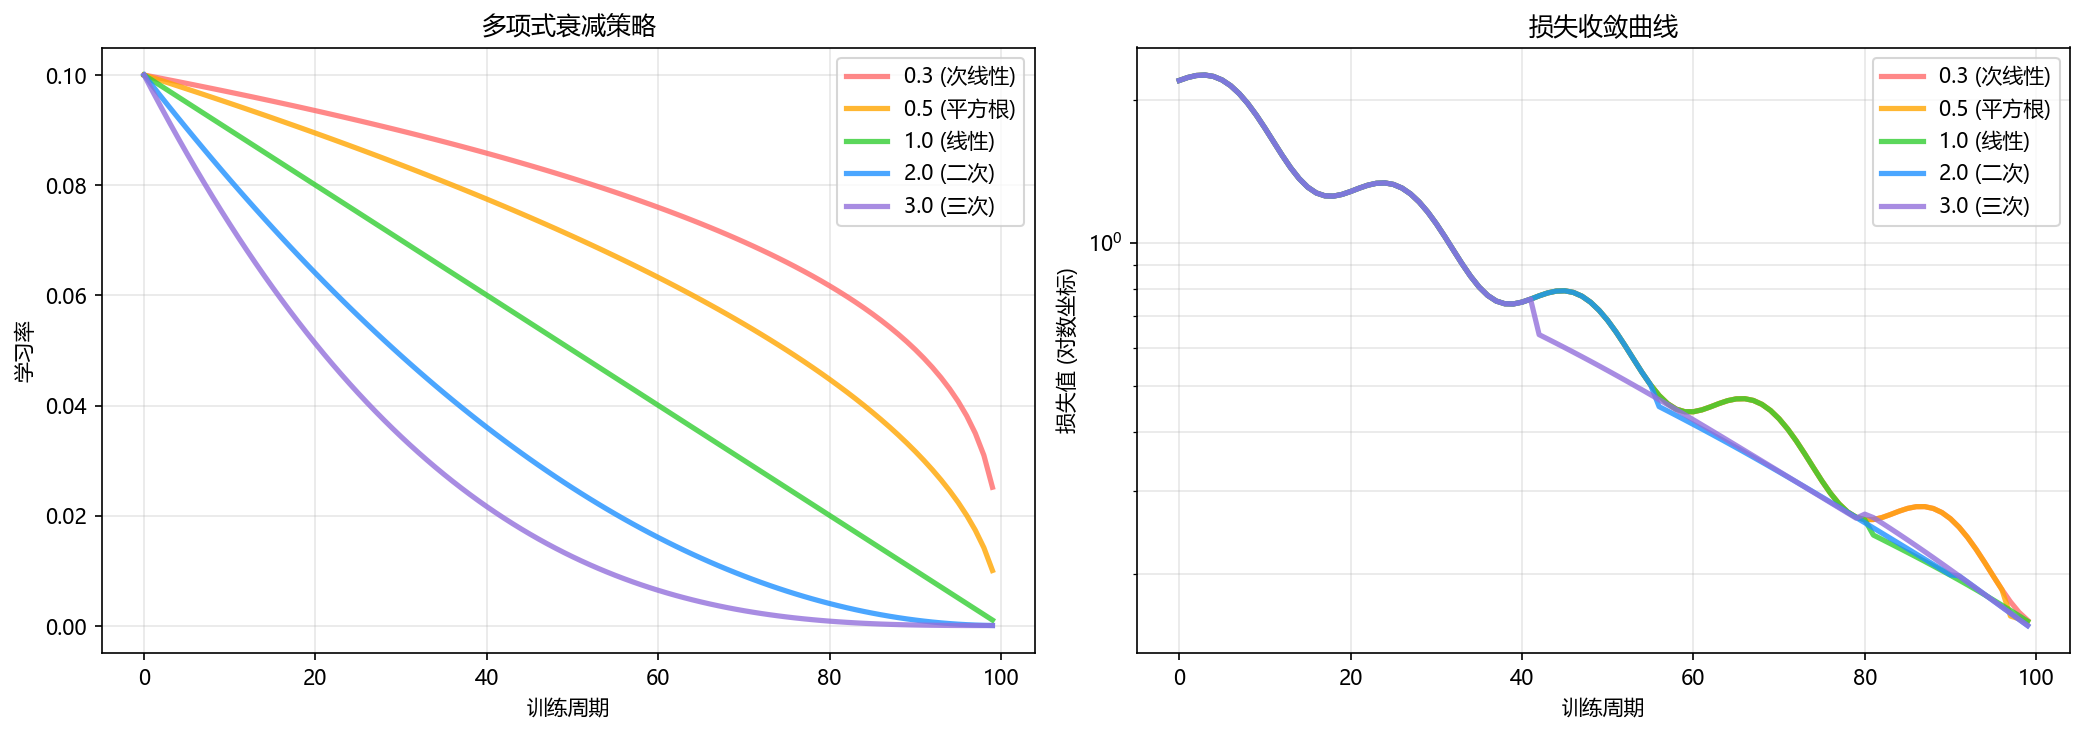

In [31]:
# 参数设置
initial_lr = 0.1
epochs = np.arange(100)

# 多项式衰减函数
def polynomial_decay(epoch, power=1.0, total_epochs=100, end_factor=0.001):
    if epoch >= total_epochs:
        return initial_lr * end_factor
    decay_factor = (1 - epoch / total_epochs) ** power
    lr = initial_lr * (end_factor + (1 - end_factor) * decay_factor)
    return lr

# 不同幂次值
powers = [0.3, 0.5, 1.0, 2.0, 3.0]
power_names = ['0.3 (次线性)', '0.5 (平方根)', '1.0 (线性)', '2.0 (二次)', '3.0 (三次)']
colors = ['#FF6B6B', '#FFA500', '#32CD32', '#1E90FF', '#9370DB']

# 模拟损失函数
def simulate_loss(lr_vals):
    losses = []
    base_loss = 2.0

    for i, (epoch, lr) in enumerate(zip(epochs, lr_vals)):
        base_decay = np.exp(-epoch * 0.025)

        if lr > 0.02:
            lr_penalty = 1.1 + 0.15 * np.sin(epoch * 0.3)
        elif lr > 0.001:
            lr_penalty = 0.85 + 0.1 * np.exp(-(lr - 0.005)**2 / 0.0005)
        else:
            lr_penalty = 0.95 + 0.05 * np.sin(epoch * 0.1)

        current_loss = base_loss * base_decay * lr_penalty

        if i > 0:
            current_loss = min(current_loss, losses[-1] * 1.02)

        losses.append(max(current_loss, 0.01))

    return np.array(losses)

# 创建图表
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：不同幂次的多项式衰减策略
for p, p_name, color in zip(powers, power_names, colors):
    lr_vals = [polynomial_decay(e, power=p) for e in epochs]
    axes[0].plot(epochs, lr_vals, linewidth=2.5, alpha=0.8,
                label=p_name, color=color)

axes[0].set_xlabel('训练周期')
axes[0].set_ylabel('学习率')
axes[0].set_title('多项式衰减策略')
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='upper right')

# 右图：对应的损失收敛曲线
for p, p_name, color in zip(powers, power_names, colors):
    lr_vals = [polynomial_decay(e, power=p) for e in epochs]
    losses = simulate_loss(lr_vals)
    axes[1].semilogy(epochs, losses, linewidth=2.5, alpha=0.8,
                    label=p_name, color=color)

axes[1].set_xlabel('训练周期')
axes[1].set_ylabel('损失值 (对数坐标)')
axes[1].set_title('损失收敛曲线')
axes[1].grid(True, alpha=0.3, which='both')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()